In [1]:
import numpy as np
import pandas as pd
import pathlib
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

# Baseline method: AutoARIMA

Use AutoARIMA to generate baseline quantile forecasts. 

In [2]:
EXPERIMENT_NAME = "autoarima"
set_frequency = 'W'

## Forecasting function

AutoARIMA is a univariate forecasting method. This function expects that `df` has a time series index (monthly samples) and the target data column is the 0th index in the dataframe (see cell line 15).

In [3]:
def get_forecast_ARIMA_weekly(
    df,
    context_length=52,
    prediction_length=12,
    cutoff_date=None,
):
    
    global forecast_date_index 
    global all_quantiles
    global forecast_min_date
    global forecast_max_date
    
    df = df.resample('W').mean().interpolate()
    quantiles = [0.01, 0.05, 0.1, 0.25, 0.75, 0.9, 0.95, 0.99]
    fh = ForecastingHorizon(list(range(1, prediction_length + 1)))

    if cutoff_date is None:
        date = df.index[-1]
    else:    
        date = pd.to_datetime(cutoff_date)
    context_df = df.loc[df.index <= date][df.columns[0]]
    model = AutoARIMA()
    model.fit(context_df, fh=fh)
    all_quantiles = {}
    for q in quantiles:
        fc_series = model.predict_quantiles(fh=fh, X=None, alpha=q)["Quantiles"]
        all_quantiles[f"q_{q}"] = fc_series[q].values
    all_quantiles["q_0.5"] = model.predict(fh=fh, X=None).values

    forecast_min_date = date + pd.DateOffset(weeks=1)
    forecast_max_date = date + pd.DateOffset(weeks=1 * prediction_length)
    forecast_date_index = pd.date_range(
        forecast_min_date, forecast_max_date, freq=set_frequency
    )

    forecast_df = pd.DataFrame(all_quantiles).set_index(
        forecast_date_index
    ).resample(set_frequency).mean()

    forecast_df = forecast_df[sorted(forecast_df.columns)]

    context_df = context_df.loc[context_df.index >= (date - pd.DateOffset(weeks=context_length))]
    return context_df, forecast_df

## Load data

Since this is a simple univariate / autoregressive model, we're only loading the 'target' CPI variables here.

In [5]:
df = pd.read_csv("../data/processed_data_inputs/Connex.csv", index_col=0)
df.index = pd.to_datetime(df.index)
df.head()

,IS_MENTAL_HEALTH,IS_SUBSTANCE_ABUSE,IS_PROBLEM_GAMBLING,IS_OTHER,IS_MENTAL_HEALTH_Concurrent Disorder Clients,IS_SUBSTANCE_ABUSE_Concurrent Disorder Clients,IS_PROBLEM_GAMBLING_Concurrent Disorder Clients,IS_OTHER_Concurrent Disorder Clients,IS_MENTAL_HEALTH_Concurrent Disorders,IS_SUBSTANCE_ABUSE_Concurrent Disorders,...,IS_PROBLEM_GAMBLING_Spanish,IS_OTHER_Spanish,IS_MENTAL_HEALTH_Italian,IS_SUBSTANCE_ABUSE_Italian,IS_PROBLEM_GAMBLING_Italian,IS_OTHER_Italian,IS_MENTAL_HEALTH_Caribbean,IS_SUBSTANCE_ABUSE_Caribbean,IS_PROBLEM_GAMBLING_Caribbean,IS_OTHER_Caribbean
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-01,40,30,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-02,68,69,7,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-03,68,45,11,0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-04,89,50,11,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-05,100,107,12,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Ensure the dataframe only contains the dates necessary 
df = df.loc[df.index >= '2018-01-01']

In [6]:
target_categories = ['IS_MENTAL_HEALTH', 'IS_SUBSTANCE_ABUSE']
target_categories

['IS_MENTAL_HEALTH', 'IS_SUBSTANCE_ABUSE']

## Define experiment cutoff dates

Our experiment design uses 6 annual cutoff dates that simulate the generation of forecast once per year over the last 6 years. We'll comsume data up to each cutoff date to fit/train models, and then evaluate over the next 18 months. In this notebook, we're only concerned with producing the retrospective forecasts and we'll do the analysis all together in another notebook.

In [7]:
report_sim_dates = open("../data/utils/experiment_cutoff_dates.txt", 'r').read().split()
report_sim_dates

['2020-3-1',
 '2020-9-27',
 '2021-3-14',
 '2021-9-5',
 '2021-12-12',
 '2022-4-3',
 '2022-7-31']

## Plot forecast range with context

We could add different elements to plots including some error analysis, emphasis on different quantiles, etc.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_quantile_forecast(category, context_df, forecast_df, actual_df, cutoff_date, save_path=None, show_plots=True):

    fig, ax = plt.subplots(figsize=(10,6))

    # Context
    context_df = pd.concat((context_df, actual_df))
    ax.plot(context_df.index, context_df.values, color='black', label='Ground Truth')

    # Confidence range between 0.01 and 0.99 quantiles
    ax.fill_between(
        forecast_df.index,
        forecast_df[f"q_0.05"],
        forecast_df[f"q_0.95"],
        facecolor='purple',
        alpha=0.5,
        label='95% Confidence'
    )

    # Add a line trace for the median
    ax.plot(forecast_df.index, forecast_df[f"q_0.5"], color='purple', label='Median Forecast')

    # Update the layout as needed
    ax.set_title(f'{category}\nRetrospective Forecast - {cutoff_date} - COVID-19 Wave#{wave_num}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Interactions')
    ax.axvline(pd.to_datetime(cutoff_date), label="Cutoff Date", color='black', ls='--', ms=1, alpha=0.5)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)

    # Show the figure
    plt.grid(axis='y')

    if show_plots:
        plt.show()

    # Save the figure if the path is specified
    if save_path:
        fig.savefig(save_path, dpi=300 if save_path.endswith("png") else None) # High res for png


## Main experiment loop

/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa

/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: C

/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/h/kupfersk/.l

/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/h/kupfersk/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


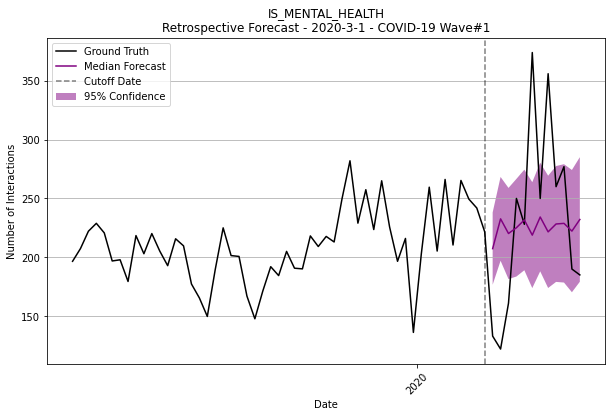

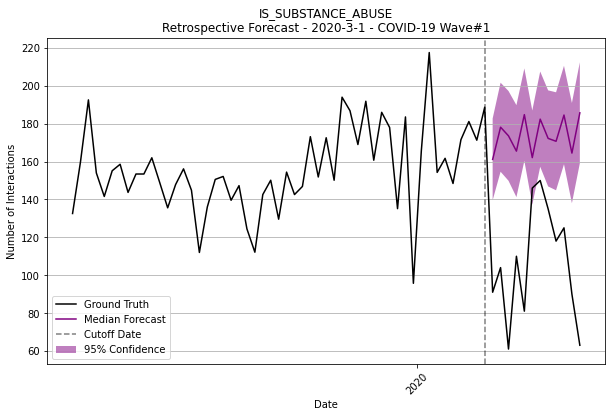

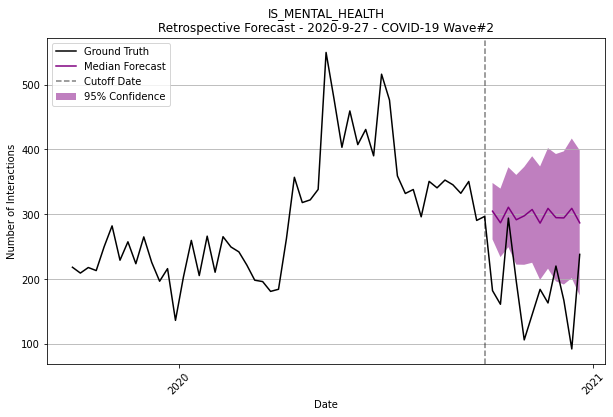

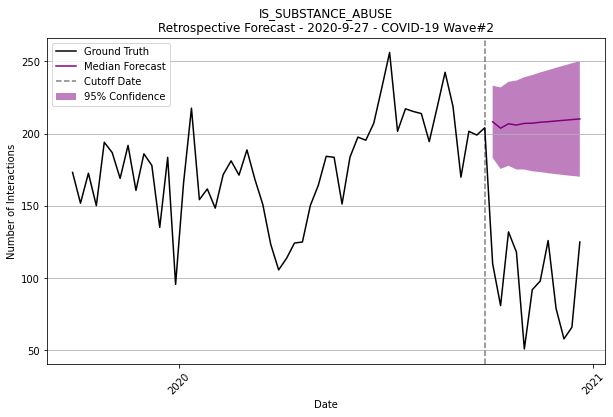

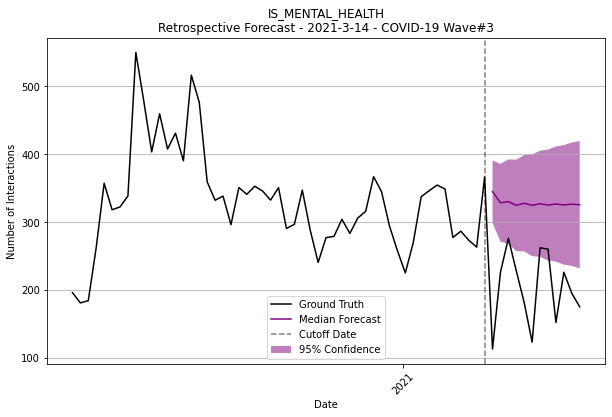

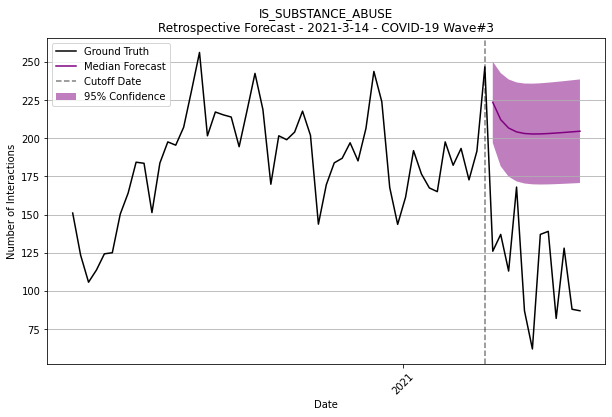

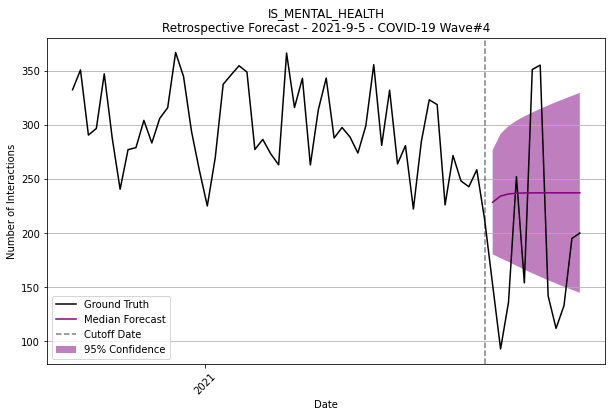

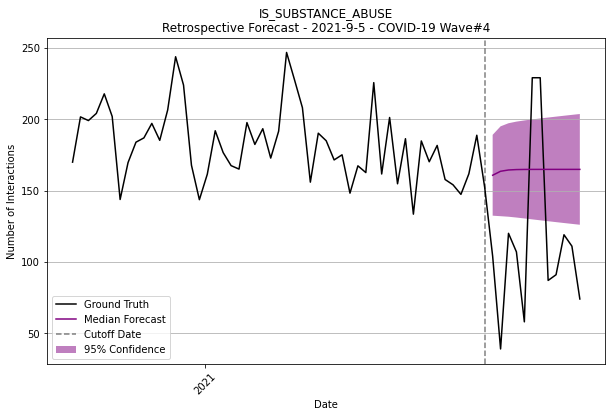

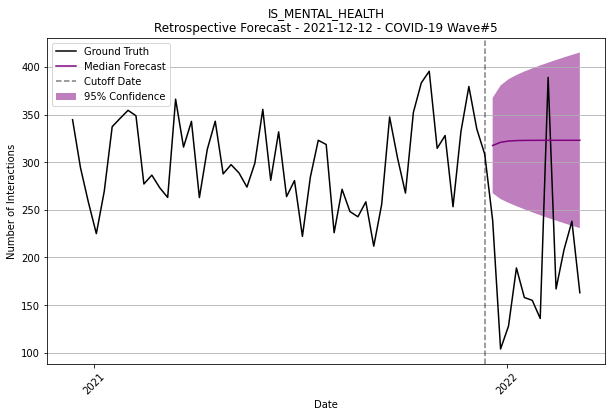

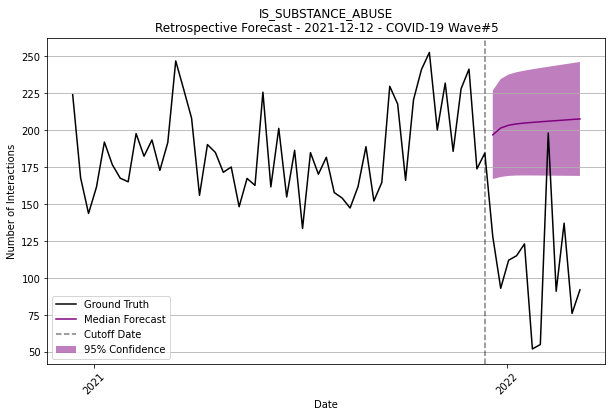

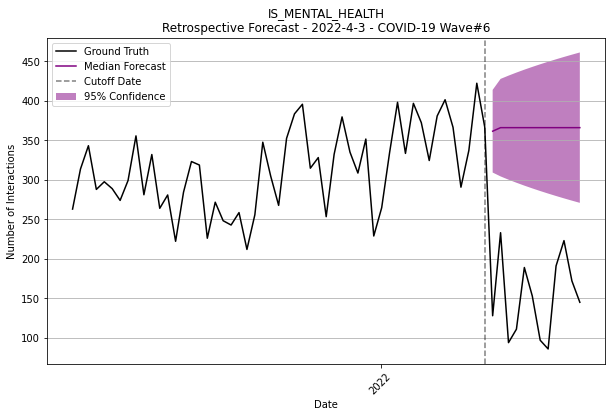

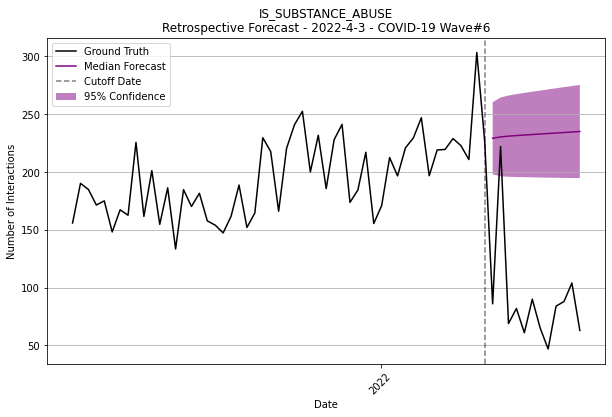

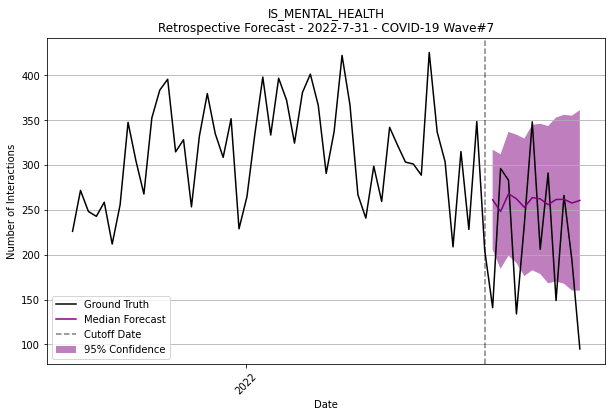

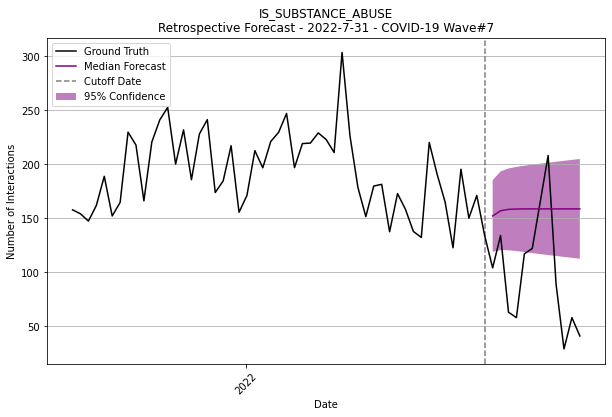

In [9]:
wave_num = 1
for cutoff_date in report_sim_dates:
    forecast_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{cutoff_date}/forecasts"
    plot_output_dir = f"./output/experiments/{EXPERIMENT_NAME}/{cutoff_date}/plots"
    pathlib.Path(forecast_output_dir).mkdir(parents=True, exist_ok=True)
    pathlib.Path(plot_output_dir).mkdir(parents=True, exist_ok=True)
    for category in target_categories:
        context_df, forecast_df = get_forecast_ARIMA_weekly(
            df[[category]],  # Indexing this way to get a dataframe with 1 column as opposed to a series
            context_length=52,      # Context length not used for ARIMA model fitting, so this just determines the amount of historical data to return 
            cutoff_date=cutoff_date    # Training / fitting cutoff date
        )
        forecast_df.to_csv(f"{forecast_output_dir}/{category}.csv")
        plot_quantile_forecast(
            category=category,         # The target category name
            context_df=context_df,     # Historical data to plot
            forecast_df=forecast_df,   # Quantile forecast dataframe
            actual_df=df[category].loc[[date for date in forecast_df.index if date in df.index]], # 'actual' data to plot against forecast
            save_path=f"{plot_output_dir}/{category}.svg", 
            cutoff_date=cutoff_date,
            show_plots=False
        )
        
    wave_num +=1